Import packages

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output  # this has to be removed if used on a single script
import random
from preprocess import preprocess_seismo, preprocess_coord
from scipy.ndimage.interpolation import shift
import GPy
import time

# AE compression

Define auxiliary functions

In [2]:
def next_batch(x, y, mb_size):
    idx = np.arange(len(x), dtype = np.int64)
    np.random.shuffle(idx)
    idx = idx[:mb_size]
    return x[idx], y[idx], idx

def plot(x, index=0):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, label='Reconstructed')
    plt.plot(X_data[index], label='Real')
    plt.legend()

def plot_test(x, index=0):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, label='Reconstructed')
    plt.plot(X_data_test[index], label='Real')
    plt.legend()

def calculate_R2(original, prediction, label, store):
    AM = original.mean()
    BM = prediction.mean()
    c_vect = (original-AM)*(prediction-BM)
    d_vect = (original-AM)**2
    e_vect = (prediction-BM)**2
    r_out = np.sum(c_vect)/float(np.sqrt(np.sum(d_vect)*np.sum(e_vect)))
    print(label+str(r_out))
    store.append(r_out)

Define number of time components in seismograms, number of coordinates, train/test split and load data

In [3]:
X_dim = 501 # size of the seismograms
y_dim = 4
# load data
split = 2000
test_valid = 1000
X_data_ = np.loadtxt('./seismograms_4000seismo_ISO.txt')[:, :X_dim]
y_data_ = np.loadtxt('./coordinates_4000seismo_ISO.txt')

In [4]:
# analysis starts here, so we start counting time from here
#start_time = time.time()

In [5]:
# preprocess coordinates
y_data_preprocessed, meancoords, stdcoords = preprocess_coord(y_data_, split=split, test_valid=test_valid, sort=False, std=True)
y_data = y_data_preprocessed[:split]
y_data_valid =  y_data_preprocessed[split:split+test_valid]
y_data_test =  y_data_preprocessed[split+test_valid:]

Shifted and standardized; not sorted
Mean: [-1.49500000e-01  6.00000000e-02 -1.23196500e+02  1.29906166e+02], std dev: [23.03473789 23.21808347 68.8275736  64.09918073]


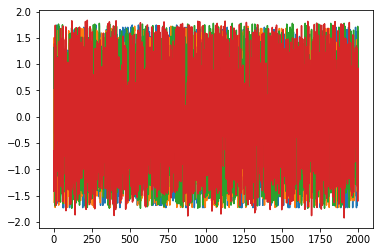

In [6]:
for i in range(y_dim):
    plt.plot(y_data[:, i])

In [7]:
# preprocess seismograms
X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=True, rescale_onlyamp=False)
X_data = X_data_preprocessed[:split]
X_data_valid =  X_data_preprocessed[split:split+test_valid]
X_data_test =  X_data_preprocessed[split+test_valid:]

('Amplitude of first peak in reference seismo', 4476.40283203125)
('Time index of first peak in reference seismo', 204)
Saving amplitude ratios and shift indices
Rescaling only.


In [8]:
amplitude_rescale = np.loadtxt('./amplitude_rescale_NOTsorted.txt')
shift_index = np.loadtxt('./shift_index_NOTsorted.txt')

In [9]:
amplitude_rescale_train = amplitude_rescale[:split].reshape(X_data.shape[0], 1)
amplitude_rescale_valid = amplitude_rescale[split:split+test_valid]
amplitude_rescale_test = amplitude_rescale[split+test_valid:]

shift_index_train = shift_index[:split].reshape(X_data.shape[0], 1)
shift_index_valid = shift_index[split:split+test_valid]
shift_index_test = shift_index[split+test_valid:]

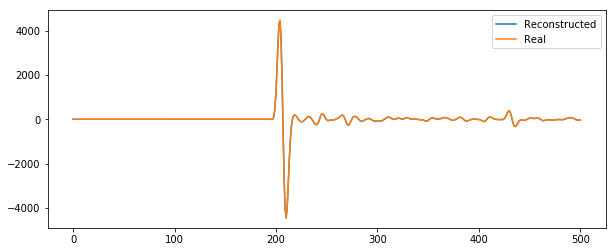

In [10]:
plot(X_data[0], 0)

We define the autoencoder first

In [11]:
# define network
mb_size = 256 # batch size
z_dim = 5 # dimension of the latent space
h1_dim = 64 # dimension of the hidden layer, i.e. number of nodes
h2_dim = 128 # dimension of the hidden layer, i.e. number of nodes
h3_dim = 256 # dimension of the hidden layer, i.e. number of nodes
h_dim = 50
#h4_dim = 600 # dimension of the hidden layer, i.e. number of nodes
conv = False # whether the network is going to be convolutional or not
conv_1, kernel_1, stride_1 = 32, 11, 2
conv_2, kernel_2, stride_2 = 16, 9, 2
#conv_3, kernel_3, stride_3 = 32, 16, 2
conv_nodes = 200
lr = 1e-3  # learning rate

def parametric_relu(_x):
    #return tf.nn.leaky_relu(_x, alpha=0.8)
    alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.glorot_normal_initializer,
                        dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5
    return pos + neg

act_f = getattr(tf.nn, 'leaky_relu') #parametric_relu #getattr(tf.nn, 'leaky_relu') # activation function

In [12]:
tf.reset_default_graph() #this will eliminate the variables we restored
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
bsize = tf.placeholder(tf.int32)

#filter_deconv0 = tf.Variable(tf.random_normal([kernel_3-y_dim, conv_2, conv_3]))
filter_deconv1 = tf.Variable(tf.random_normal([kernel_2, conv_1, conv_2]))
filter_deconv2 = tf.Variable(tf.random_normal([kernel_1, 1, conv_1]))


# the encoder
def Q(X):
    inputs = X #tf.concat(axis=1, values=[X, c])
    if conv:
        inputs1 = tf.reshape(inputs, [-1, X_dim, 1]) # reshape to 3D
        print(inputs1.shape)
        h = tf.layers.conv1d(inputs1, conv_1, kernel_1, strides=stride_1, padding='valid', activation=act_f)
        print(h.shape)
        h_ = tf.nn.max_pool1d(h, 2, strides=2, padding='VALID')
        print(h_.shape)
        h2 = tf.layers.conv1d(h_, conv_2, kernel_2, strides=stride_2, padding='valid', activation=act_f)
        print(h2.shape)
        h2_ = tf.nn.max_pool1d(h2, 2, strides=2, padding='VALID')
        print(h2_.shape)
        h3 = tf.reshape(h2_, [-1, h2_.shape[1]*h2_.shape[2]])
        #h3 = tf.layers.conv1d(h2_, conv_3, kernel_3, strides=stride_3, padding='valid')
        print(h3.shape)
        h4 = tf.layers.dense(h3, conv_nodes, activation=act_f)
        h5 = tf.layers.dense(h4, z_dim)
        z_mu = tf.reshape(h5, [-1, z_dim])
        z_logvar = tf.constant(0.0) #tf.constant(z_dim*[np.log(prior_std**2)]) #tf.layers.dense(h4, z_dim)
    else:
        h3 = tf.layers.dense(inputs, h3_dim, activation=act_f)
        h2 = tf.layers.dense(h3, h2_dim, activation=act_f)
        h1 = tf.layers.dense(h2, h1_dim, activation=act_f)
        z_mu = tf.layers.dense(h1, z_dim)
        z_logvar = tf.constant(0.0) # tf.constant(z_dim*[np.log(prior_std**2)]) #tf.layers.dense(h4, z_dim)
    return z_mu, z_logvar


# the decoder
def P(zed, bsize):
    inputs = zed #tf.concat(axis=1, values=[zed, c])
    if conv:
        h5 = tf.layers.dense(inputs, conv_nodes, activation=act_f)
        print(h5.shape)
        h4_ = tf.layers.dense(h5, 29*conv_2, activation=act_f)
        print(h4_.shape)
        h4_res = tf.reshape(h4_, [-1, 29, conv_2])
        print(h4_res.shape)
        h4 = tf.keras.layers.UpSampling1D(2)(h4_res)
        print(h4.shape)
        h3 = tf.nn.conv1d_transpose(h4, filter_deconv1, output_shape=[bsize, 123, conv_1], strides=stride_2, padding='VALID')
        h3_ = act_f(h3)
        print(h3_.shape)
        h3__ = tf.keras.layers.UpSampling1D(2)(h3_)
        print(h3__.shape)
        h2 = tf.nn.conv1d_transpose(h3__, filter_deconv2, output_shape=[bsize, X_dim, 1], strides=stride_1, padding='VALID')
        print(h2.shape)
        h1 = tf.reshape(h2, [-1, X_dim])
        logits = h1
    else:
        #print('Not conv')
        h1 = tf.layers.dense(inputs, h1_dim, activation=act_f)
        h2 = tf.layers.dense(h1, h2_dim, activation=act_f)
        h3 = tf.layers.dense(h2, h3_dim, activation=act_f)
        logits = tf.layers.dense(h3, X_dim)
    return logits


In [13]:
z_sample, _ = Q(X)
#z_sample = sample_z(z_mu)

decoder = tf.make_template('decoder', P)
X_samples_rand = decoder(z, bsize)
X_samples = decoder(z_sample, bsize)

# reconstruction loss
recon_loss = tf.keras.losses.MSE(X, X_samples)#tf.losses.mean_squared_error(X, logits)
#tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)

# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
#kl_loss = tf.constant([0.0]) #0.5 * tf.reduce_mean(tf.exp(z_logvar)/(prior_std**2) + z_mu**2/(prior_std**2) - 1. - z_logvar + np.log(prior_std**2), 1) #tf.constant(0.0) #0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Here we define the internal NN that maps coordinates to learnt latent features

In [14]:
#second part
def latent_P(coord):
    h1 = tf.layers.dense(coord, h_dim, activation=act_f)
    h2 = tf.layers.dense(h1, h_dim, activation=act_f)
    h3 = tf.layers.dense(h2, h_dim, activation=act_f)
    logits = tf.layers.dense(h3, z_dim)
    return logits

z_nn_samples = latent_P(c)

# reconstruction loss
recon_loss_nn = tf.keras.losses.MSE(z, z_nn_samples)

# loss
loss_nn = tf.reduce_mean(recon_loss_nn)

solver_nn = tf.train.AdamOptimizer().minimize(loss_nn)

In [15]:
saver = tf.train.Saver(max_to_keep=None)

In [16]:
sess = tf.Session()

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
# losses = []
# valid_losses = []

# training_AE_R2 = []
# validation_AE_R2 = []
# test_AE_R2 = []

# n_epochs = 100 # number of epochs
# best_loss = 1e8
# stopping_step = 0
# patience = 100

# for epoch in range(n_epochs):
    
#     # training
#     random_perm = np.random.permutation(X_data.shape[0])
#     mini_batch_index = 0
#     while True:
#         indices = random_perm[mini_batch_index:mini_batch_index+mb_size]
#         sess.run(solver, feed_dict={X: X_data[indices], bsize: X_data[indices].shape[0]})
#         mini_batch_index += mb_size
#         if mini_batch_index >= X_data.shape[0]:
#             break

#     # metrics       
#     clear_output(wait=True)

#     loss, rec = sess.run([vae_loss, recon_loss], feed_dict={X: X_data, bsize: split})
#     valid_loss, valid_rec = sess.run([vae_loss, recon_loss], feed_dict={X: X_data_valid, bsize: test_valid})

#     losses.append(loss)
#     #losses_rec.append(np.mean(rec))

#     valid_losses.append(valid_loss)
#     #valid_losses_rec.append(np.mean(valid_rec))


#     print('Epoch: {}'.format(epoch))
#     print('Loss: {:.4}'.format(np.mean(rec)))
#     print('Validation loss: {:.4}'.format(np.mean(valid_rec)))

#     #X_R2, _, _ = next_batch(X_data, X_data, 2000)
#     #prediction_training = sess.run(X_samples, feed_dict={X: X_R2, bsize: split})
#     #calculate_R2(X_R2, prediction_training, 'Training AE: ', training_AE_R2)
#     #prediction_validation = sess.run(X_samples, feed_dict={X: X_data_valid, bsize: test_valid})
#     #calculate_R2(X_data_valid, prediction_validation, 'Validation AE: ', validation_AE_R2)
#     #prediction_test = sess.run(X_samples, feed_dict={X: X_data_test, bsize: test_valid})
#     #calculate_R2(X_data_test, prediction_test, 'Test AE: ', test_AE_R2)

#     loss_value = np.mean(valid_rec)
#     if loss_value < best_loss:
#         stopping_step = 0
#         best_loss = loss_value
#         save_path = saver.save(sess, "./AE_plus_NN/AEtrained/best_AE_model_receiver0.ckpt")
#     else:
#         stopping_step += 1
#         print('Early stopping: {}/{}'.format(stopping_step, patience))
#     if stopping_step >= patience:
#         print('Patience limit reached at epoch {}'.format(epoch))
#         break

# fig = plt.figure(figsize=(10, 4))
# plt.plot(losses, label='Training')        
# plt.plot(valid_losses, label='Validation')        
# plt.legend()
# plt.show()

In [19]:
#prediction_test = sess.run(X_samples, feed_dict={X: X_data_test, bsize: test_valid})
#calculate_R2(X_data_test, prediction_test, 'Test AE: ', test_AE_R2)

In [20]:
# load best AE model
# print('Best model was model {}'.format(len(losses) - patience))
load_path = ("./saved_models_iso_AEplusNN_AE/best_model.ckpt")
saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from ./saved_models_iso_AEplusNN_AE/best_model.ckpt


In [21]:
# now the second part
z_values_train = sess.run(z_sample, feed_dict={X: X_data, bsize: split})
z_values_valid = sess.run(z_sample, feed_dict={X: X_data_valid, bsize: test_valid})
#z_values_test = sess.run(z_sample, feed_dict={X: X_data_test, bsize: test_valid})

In [22]:
zmean = np.mean(z_values_train)
zstd = np.std(z_values_train)
z_values_train = (z_values_train - zmean)/zstd
z_values_valid = (z_values_valid - zmean)/zstd
#z_values_test = (z_values_test - zmean)/zstd

In [23]:
# losses_rec_nn = []
# valid_losses_rec_nn = []

# training_nn_R2 = []
# validation_nn_R2 = []
# test_nn_R2 = []

# n_epochs = 100 # number of epochs
# best_loss = 1e8
# stopping_step = 0
# patience = 100

# for epoch in range(n_epochs):

#     # training
#     random_perm = np.random.permutation(z_values_train.shape[0])
#     mini_batch_index = 0
#     while True:
#         indices = random_perm[mini_batch_index:mini_batch_index+mb_size]
#         sess.run(solver_nn, feed_dict={z: z_values_train[indices], c: y_data[indices]})
#         mini_batch_index += mb_size
#         if mini_batch_index >= z_values_train.shape[0]:
#             break


#     # metrics    
#     clear_output(wait=True)

#     rec = sess.run(recon_loss_nn, feed_dict={z: z_values_train, c: y_data})
#     valid_rec = sess.run(recon_loss_nn, feed_dict={z: z_values_valid, c: y_data_valid})

#     losses_rec_nn.append(np.mean(rec))
#     valid_losses_rec_nn.append(np.mean(valid_rec))

#     print('Epoch: {}'.format(epoch))
#     print('Rec loss: {:.4}'.format(np.mean(rec)))
#     print('Validation rec loss: {:.4}'.format(np.mean(valid_rec)))

#     #X_R2, y_R2, _ = next_batch(X_data, y_data, split)
#     #prediction_z_training = sess.run(z_nn_samples, feed_dict={c: y_R2})
#     #prediction_z_training = prediction_z_training * zstd + zmean
#     #prediction_training = sess.run(X_samples_rand, feed_dict={z: prediction_z_training, bsize: split})        
#     #calculate_R2(X_R2, prediction_training, 'Training AE+NN: ', training_nn_R2)
#     #calculate_R2(z_values_train, prediction_z_training, 'Training NN: ', training_nn_R2)

    
#     #prediction_z_valid = sess.run(z_nn_samples, feed_dict={c: y_data_valid})
#     #prediction_z_valid = prediction_z_valid * zstd + zmean
#     #prediction_valid = sess.run(X_samples_rand, feed_dict={z: prediction_z_valid, bsize: test_valid})
#     #calculate_R2(X_data_valid, prediction_valid, 'Validation AE+NN: ', validation_nn_R2)
#     #calculate_R2(z_values_valid, prediction_z_valid, 'Validation NN: ', validation_nn_R2)


#     #prediction_z_test = sess.run(z_nn_samples, feed_dict={c: y_data_test})
#     #prediction_z_test = prediction_z_test * zstd + zmean
#     #prediction_test = sess.run(X_samples_rand, feed_dict={z: prediction_z_test, bsize: test_valid})
#     #calculate_R2(X_data_test, prediction_test, 'Test AE+NN: ', test_nn_R2)
#     #calculate_R2(z_values_test, prediction_z_test, 'Test NN: ', test_nn_R2)

#     loss_value = np.mean(valid_rec)
#     if loss_value < best_loss:
#         stopping_step = 0
#         best_loss = loss_value
#         save_path = saver.save(sess, "./AE_plus_NN/NNtrained/best_NN_model_receiver0.ckpt")
#     else:
#         stopping_step += 1
#         print('Early stopping: {}/{}'.format(stopping_step, patience))
#     if stopping_step >= patience:
#         print('Patience limit reached at epoch {}'.format(epoch))
#         break

# fig = plt.figure(figsize=(10, 4))
# plt.plot(losses_rec_nn, label='Training')        
# plt.plot(valid_losses_rec_nn, label='Validation')        
# plt.legend()
# plt.show()

In [24]:
# load best AE+NN model
#print('Best model was model {}'.format(len(losses_rec_nn) - patience))
load_path = ("./saved_models_iso_AEplusNN_NN/best_model.ckpt")
saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from ./saved_models_iso_AEplusNN_NN/best_model.ckpt


# GP training for Amplitude and Time shifts

In [25]:
# # fit GP to data rescaling
# # amplitude
# kern = GPy.kern.Matern32(4,ARD=True)
# n = GPy.models.GPRegression(y_data, amplitude_rescale_train, kern)
# n.optimize(messages=True, max_f_eval = 1000)

# # GP softwares should have regularisation techniques to prevent overfitting
# # already implemented. This way, we can just look at training performance, 
# # as in, that training converged, to be quite sure it did not overfit.
# # As a confirmation of this, we print train and validation R2 scores, 
# # and check they are compatible. If they are not, then overfit happened,
# # maybe because the size sample was too small and regularisation techniques failed.
# # If they are on par, then there is good generalisation and no signs of overfitting.
# # We note that overfitting may have happened anyway, as this is just a necessary, 
# # but not sufficient, condition. However, we expect the algorithm to be robust enough
# # when trained on these representative data that by just looking at train and
# # validation R2 values we can exclude overfitting.

# y_pred_train = n.predict(y_data)[0]
# y_pred_train = y_pred_train[:, 0]
# calculate_R2(amplitude_rescale_train.flatten(), y_pred_train, 'Amplitude R2 train: ', [])

# y_pred_valid = n.predict(y_data_valid)[0]
# y_pred_valid = y_pred_valid[:, 0]
# calculate_R2(amplitude_rescale_valid, y_pred_valid, 'Amplitude R2 validation: ', [])

# # this is to be used later
# y_pred_test = n.predict(y_data_test)[0]
# y_pred_test = y_pred_test[:, 0]

# #plt.plot(amplitude_rescale_test, color='blue')
# #plt.show()
# #plt.plot(y_pred_test, color='red')
# #plt.show()

In [26]:
# # time shift
# ker = GPy.kern.Matern32(4,ARD=True)
# m = GPy.models.GPRegression(y_data,shift_index_train,ker)
# m.optimize(messages=True,max_f_eval = 1000)

# y_pred_train_2 = m.predict(y_data)[0]
# y_pred_train_2 = y_pred_train_2[:, 0]
# calculate_R2(shift_index_train.flatten(), y_pred_train_2, 'Time shift R2 training: ', [])

# y_pred_valid_2 = m.predict(y_data_valid)[0]
# y_pred_valid_2 = y_pred_valid_2[:, 0]
# calculate_R2(shift_index_valid, y_pred_valid_2, 'Time shift R2 validation: ', [])

# y_pred_test_2 = m.predict(y_data_test)[0]
# y_pred_test_2 = y_pred_test_2[:, 0]

# #plt.plot(shift_index_test, color='blue')
# #plt.show()
# #plt.plot(y_pred_test_2, color='red')
# #plt.show()

In [27]:
# prediction_z_test = sess.run(z_nn_samples, feed_dict={c: y_data_test})
# prediction_z_test = prediction_z_test * zstd + zmean
# prediction_testing = sess.run(X_samples_rand, feed_dict={z: prediction_z_test, bsize: test_valid})
    
# prediction_testing = np.multiply(prediction_testing, np.repeat(1/y_pred_test, X_dim).reshape(-1, X_dim))
# for index_seism in range(test_valid):
#     prediction_testing[index_seism] = shift(prediction_testing[index_seism], -y_pred_test_2[index_seism], cval=0.)

# # retrieve the unprocessed data back
# X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=False, rescale_onlyamp=False)
# X_data_test = X_data_preprocessed[split+test_valid:]

# calculate_R2(X_data_test, prediction_testing, 'Final R2 testing: ', [])

# #for i in range(5):
# #    plt.plot(X_data_test[i], color='blue')
# #    plt.plot(prediction_testing[i], color='red')
# #    plt.show()

# Inference

In [28]:
ker = GPy.kern.Matern32(4,ARD=True) 
m_load = GPy.models.GPRegression(y_data, amplitude_rescale_train, ker, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load('./saved_models_iso_AEplusNN_NN/GPmodel_amplitude.npy') # Load the parameters
m_load.update_model(True) # Call the algebra only once

kern = GPy.kern.Matern32(4,ARD=True) 
n_load = GPy.models.GPRegression(y_data, shift_index_train, kern, initialize=False)
n_load.update_model(False) # do not call the underlying expensive algebra on load
n_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
n_load[:] = np.load('./saved_models_iso_AEplusNN_NN/GPmodel_time.npy') # Load the parameters
n_load.update_model(True) # Call the algebra only once

 /home/alessio/anaconda3/lib/python2.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [34]:
start_time_inference = time.time()

coordinate = np.array([31,25,158])

shifted = coordinate - np.array([41,41,244])
distances = np.linalg.norm(shifted)
new_coords = np.zeros(4)
new_coords[:3] = shifted
new_coords[-1] = distances
new_coords = (new_coords - meancoords)/stdcoords
new_coords = new_coords.reshape((1,y_dim))

prediction_z_test = sess.run(z_nn_samples, feed_dict={c: new_coords})
prediction_z_test = prediction_z_test * zstd + zmean
prediction_testing = sess.run(X_samples_rand, feed_dict={z: prediction_z_test})
y_pred_test = m_load.predict(new_coords)[0]
y_pred_test = y_pred_test[:, 0]
y_pred_test_2 = n_load.predict(new_coords)[0]
y_pred_test_2 = y_pred_test_2[:, 0]
prediction_testing = np.multiply(prediction_testing, np.repeat(1/y_pred_test, X_dim).reshape(-1, X_dim))
prediction_testing = shift(prediction_testing[0], -y_pred_test_2, cval=0.)

timeinf = time.time() - start_time_inference
print("timeinf", timeinf)
np.save("AE_plus_NN_inftime.npy", timeinf)

# # retrieve the unprocessed data back
# X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=False, rescale_onlyamp=False)
# X_data_test = X_data_preprocessed[split+test_valid:]

# calculate_R2(X_data_test, prediction_testing, 'Final R2 testing: ', [])

#for i in range(5):
#    plt.plot(X_data_test[i], color='blue')
#    plt.plot(prediction_testing[i], color='red')
#    plt.show()

('timeinf', 0.008533000946044922)


In [30]:
# # total time, to be quoted in the paper
# print("--- %s seconds ---" % (time.time() - start_time))